# The Dataset

Our dataset is composed of recordings made by some tag around the world. These tags record at a given time some information about a storm such as strenght, location, wind speed, ... All recordings were made from 1980 onwards.

# Necessary features and expectations:

- Create a Machine Learning solution to predict the strenght of tropical storms, based on geographical inputs.
- The cateory of the strenght of the storm appear in the target column "TD9636_STAGE" of our dataset.
- We need to follow a complete pipeline to deploy an application which will take geographic coodinates as input and will return the strenght of the storm as output.

## First ideas of exploration:

- See how a storm evolve over time.
- See how the storms are affected by their location, in terms of geographi basin, in order to know if it affect their behaviours.
- See how the wind speed of a storm evolve over time.

In [11]:
# We first need to import all the packages we will use during the exploration of the dataset

#Data handling tools :
import numpy as np #Used for arithmetic operations
import pandas as pd #Used to handle the csv dataset and use it as a dataframe

#Plotting tools :
import seaborn as sns #Used for plotting
import matplotlib.pyplot as plt #Used also for plotting
import plotly.express as px #Used also for plotting
from mpl_toolkits.mplot3d import Axes3D #Used for 3d plotting and heatmap
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot #More tools for plotting offline

#Maps features tools :
import cartopy.crs as ccrs #Used for the static maps features
import cartopy.feature as cfeature #Used for the static maps features
import folium #To create an interactive map
from folium.plugins import MarkerCluster #To help us generating data on the interactive map
from geopy.distance import geodesic # Help us calculate come distances on a map
import matplotlib.colors as mcolors

#Offline tools :
import plotly.graph_objects as go #Used to acces more tools during plotting like putting notebook offline
import cufflinks as cf #Only used to put the notebook offline

#Other tools :
import missingno as msno #This help us to handle some missing values
import ipywidgets as widgets #Needed to create a slider in an intercative map
from IPython.display import display #Helping to haandle the render of some parts of the notebook
import branca.colormap as cm #This help to calculate distance from two points identified by the coordinates of those points

# ML Tools
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,accuracy_score, make_scorer, mean_squared_error, r2_score, f1_score, confusion_matrix

from xgboost import XGBClassifier

In [12]:
#Function to create the distribution
def distribution(var,df): #This function is created because we use it several time especially when plotting
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=var)
    plt.title(f"Variable distribution {var}")
    plt.xlabel("Modalities")
    plt.ylabel("Number of individuals by modality")
    plt.show()

# Loading the dataset and taking a first look at our data
By simply opening the csv dataset in Excel, we can already observe a few facts :
- The ISO_TIME column has no missing values; it has been constructed as a timeline.
- Our target, the "TD9636_STAGE" column has many missing values. Indeed, the data it contains are readings taken by a beacon when a storm appears. Fortunately, storms aren't continuous, we therefore have missing values when there are no storms.
- The values in the "TD9636_STAGE" column (target) are classes, the severity of the storm in a range from 0 to 7. Here 0 is the weakest intensity, 6 is the strongest and 7 is considered as a doubtful or unidentified record. Perhaps a multiclass classification model could be the solution.
- The columns "TD9636_LON" and "TD9636_LAT" are geographical coordinates of the record of the beacon TD9636. Those will represent the features of our model. They have missing values, with the same schema as the TD9636_STAGE. But some others column seems to record the coordinates. Indeed, we need to find the ones to keep in the model.



In [13]:
#Importing the raw dataset with pandas
# + skiping the unit row (1st under the head, because irrelevant)
# + low_memory set to False to avoid mixed types values
df = pd.read_csv("data/ibtracs.csv", skiprows = [1], low_memory=False)
df

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5,172.5,...,,,,,,,,,6,350
1,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.2,172.4,...,,,,,,,,,6,350
2,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9,172.4,...,,,,,,,,,5,360
3,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 09:00:00,TS,-11.7,172.4,...,,,,,,,,,4,10
4,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 12:00:00,TS,-11.5,172.5,...,,,,,,,,,4,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297093,2024280N18146,2024,72,WP,MM,BARIJAT,2024-10-10 00:00:00,NR,32.6,150.2,...,,,,,,,,,18,25
297094,2024280N18146,2024,72,WP,MM,BARIJAT,2024-10-10 03:00:00,NR,33.7,150.5,...,,,,,,,,,23,15
297095,2024280N18146,2024,72,WP,MM,BARIJAT,2024-10-10 06:00:00,NR,34.8,150.9,...,,,,,,,,,23,20
297096,2024280N18146,2024,72,WP,MM,BARIJAT,2024-10-10 09:00:00,NR,35.7,151.6,...,,,,,,,,,21,35


In [14]:
df_prod = df.copy()

In [15]:
#Description of the dataset
print(df.head())
print(df.describe())
print(df.shape)
print(df.info())

             SID  SEASON  NUMBER BASIN SUBBASIN  NAME             ISO_TIME  \
0  1980001S13173    1980       1    SP       MM  PENI  1980-01-01 00:00:00   
1  1980001S13173    1980       1    SP       MM  PENI  1980-01-01 03:00:00   
2  1980001S13173    1980       1    SP       MM  PENI  1980-01-01 06:00:00   
3  1980001S13173    1980       1    SP       MM  PENI  1980-01-01 09:00:00   
4  1980001S13173    1980       1    SP       MM  PENI  1980-01-01 12:00:00   

  NATURE   LAT    LON  ... BOM_GUST_PER REUNION_GUST REUNION_GUST_PER  \
0     TS -12.5  172.5  ...                                              
1     TS -12.2  172.4  ...                                              
2     TS -11.9  172.4  ...                                              
3     TS -11.7  172.4  ...                                              
4     TS -11.5  172.5  ...                                              

  USA_SEAHGT  USA_SEARAD_NE USA_SEARAD_SE USA_SEARAD_SW USA_SEARAD_NW  \
0                  

We see that 168 columns have the object type. Some pre-processing will need to be done.

In [16]:
#Trying to see the behaviour of some named stroms
df[["NAME","STORM_SPEED","STORM_DIR","SID","REUNION_LAT","REUNION_PRES"]].sample(10)

,NAME,STORM_SPEED,STORM_DIR,SID,REUNION_LAT,REUNION_PRES
258439,FLORENCE,10,315,2018242N13343,,
117969,WILLIE,5,245,1996260N19107,,
70885,STEVE,12,70,1990205N16141,,
178145,FRANKLIN,8,50,2005203N25285,,
273162,DELTA,11,355,2020279N16284,,
247775,OTTO,2,195,2016323N13279,,
266818,NEOGURI,14,55,2019288N16136,,
148372,OLIVIA,5,310,2000277N15257,,
25192,WINNIE,0,0,1983339N13257,,
9140,MAURY,12,275,1981195N11138,,


Here some variables are chosen randomly (at our discretion) to explore the dataset, we removed a lot of those columns to begin an exploration on the data. We kept those just to illustrate our reasonning.

In [17]:
sids = df["SID"].unique()
print(f"The dataset contains infos on {len(sids)} different storms")

The dataset contains infos on 4767 different storms


# First step in the Analysis
We can notice here that most of the data is missing. In the target column (TD9636_STAGE) the missing rows were filled as " ", and so they did not count as truly void.
We need to focus the analysis on the values that we have. The description of the dataset indicates that our target is composed of values that are records of storms intensity, at a point in the world at a given time. The range of those values are from 0 to 7. The value 7 is interesting because it is composed of unidentified or corrupted values.

Our target column is now of the <class 'pandas.core.series.Series'> type

This is how our target behave in the dataset : 
count     297098
unique         8
top             
freq      248755
Name: TD9636_STAGE, dtype: object

The values in our target column are ['1' '2' '4' ' ' '0' '6' '5' '3']

Below the value count inside the TD9636_STAGE column : 
TD9636_STAGE
     248755
2     17204
1     16028
4     10623
0      3156
3       742
5       331
6       259
Name: count, dtype: int64


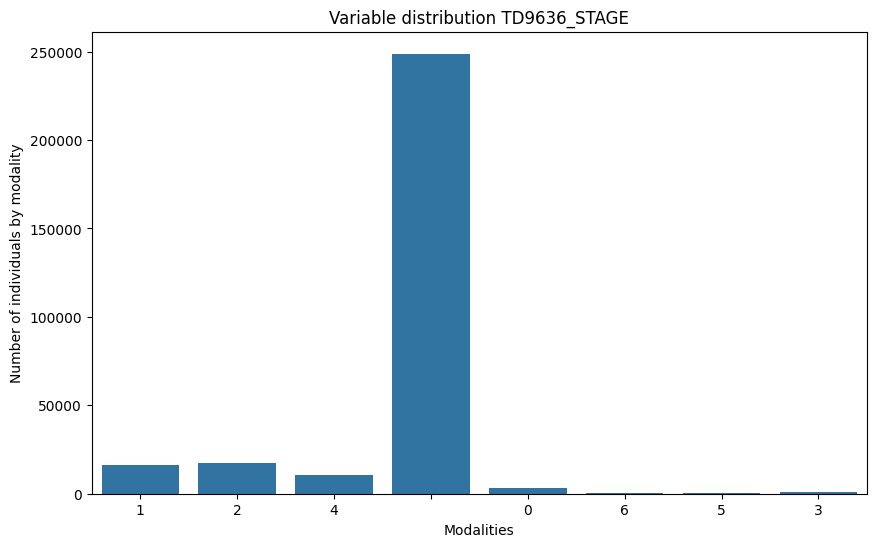

In [18]:
#The column we want to predict is TD9636_STAGE, lets take a look at it
print(f"Our target column is now of the {type(df['TD9636_STAGE'])} type\n")
print(f"This is how our target behave in the dataset : \n{df['TD9636_STAGE'].describe()}\n")
print(f"The values in our target column are {df.TD9636_STAGE.unique()}\n")
print(f"Below the value count inside the TD9636_STAGE column : \n{df.TD9636_STAGE.value_counts()}")
distribution('TD9636_STAGE', df)

When we clean up the dataset, it will also be important to manipulate the columns we need in our model:
- ISO_TIME : This column is really important as a storm evolve over time. It will be efficient to convert it to a .datetime() format.
- TD9636_STAGE : This is our target. For the moment, its format is an integer, and this seems fine for now. But we need to remove the " " values, as this will probably make our future plots irrelevant.
- TD9636_LON and TD9636_LAT : are both longitude and latitude in degrees north and east, so we need to transform them into float in order to use them on a map.

In [19]:
#There is no missing value in the target column. Indeed the missing value is a space, lets replace the " " by the value "7"
filtered_df = df.copy()
filtered_df = filtered_df.loc[df["TD9636_STAGE"] != " "] #Here is the filtered one

#Suggestion in case we have the following values " " : utilisation de regex pour " " "" "\n" "\t"
#filtered_df["TD9636_STAGE"].replace(r"^\s*$", "7", regex=True, inplace=True)

Now we have filtered the dataframe, by omitting the " " values in the new one.

## Variable "NATURE" univariate analysis
This variable is a combined storm type. It is assigned on the basis off all available storm types.
We find that, based on the distribution of the target and the NATURE feature, we don't really have links between the two.
Let's dig somewhere else.

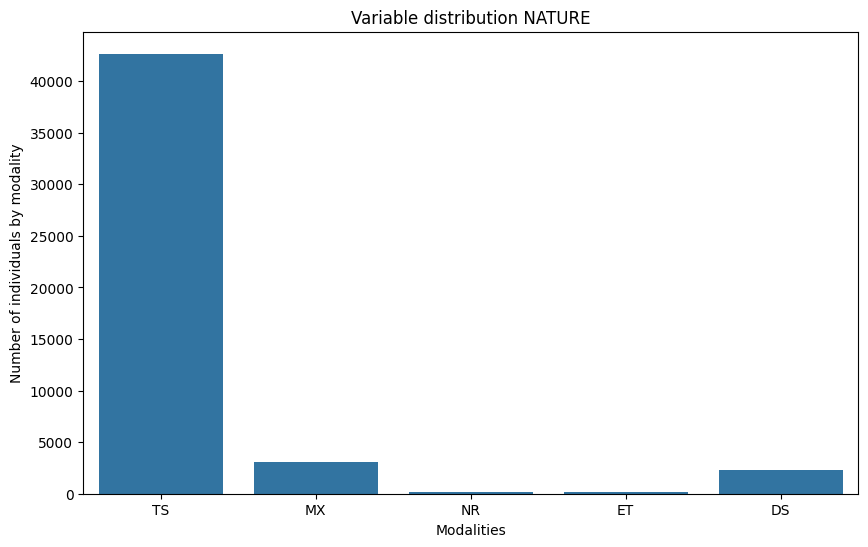

In [20]:
distribution("NATURE", filtered_df)

We see that the class TS is dominant.

## Variable "BASIN" univariate analysis
The basins are geographical zones around the world (for instance North Atlantic, Asia, ...). It is then divided into the"SUBBASIN" variable.

We see that after the replacement of the missing values in the target, no difference appear in its distribution, regarding the missing values.

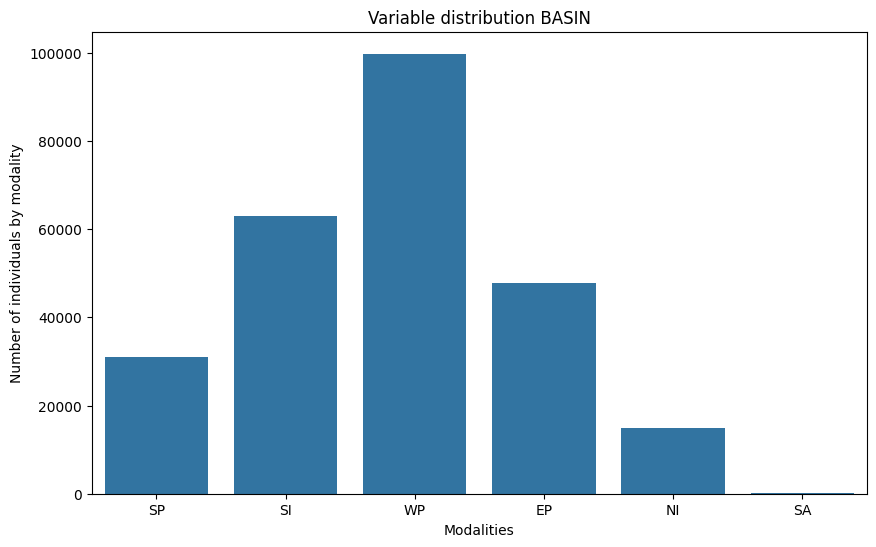

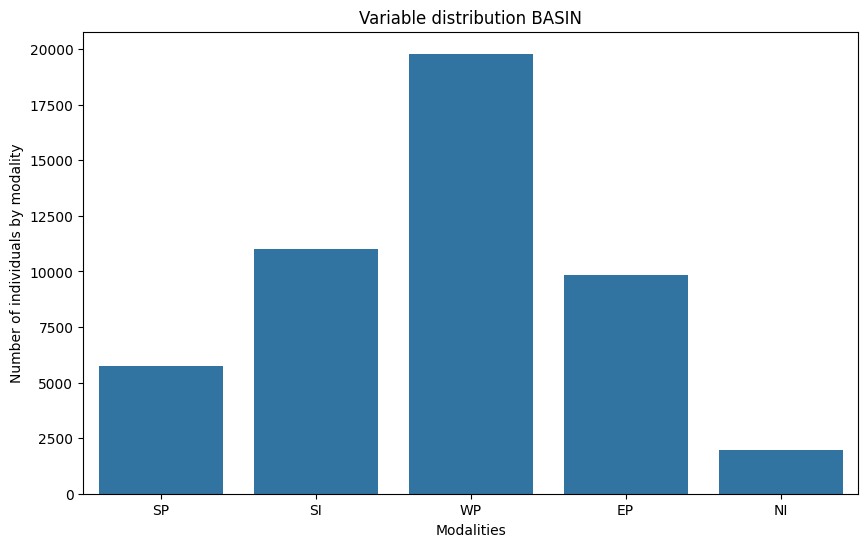

In [21]:
distribution("BASIN", df)
distribution("BASIN", filtered_df)

We see here that when we are comparing the original dataset and the filtered one we have a slight change in the distribution (SI and EP seem to balance a bit) and we are also losing one Basin.

## Variable "SEASON" univariate analysis
Here we wil have a look at the impact of the replacement in the target column on the SEASON feature.

We notice that the records of our target TD9636_STAGE has only been made from 1980 to 1989. So we will only need this period of time in our study.

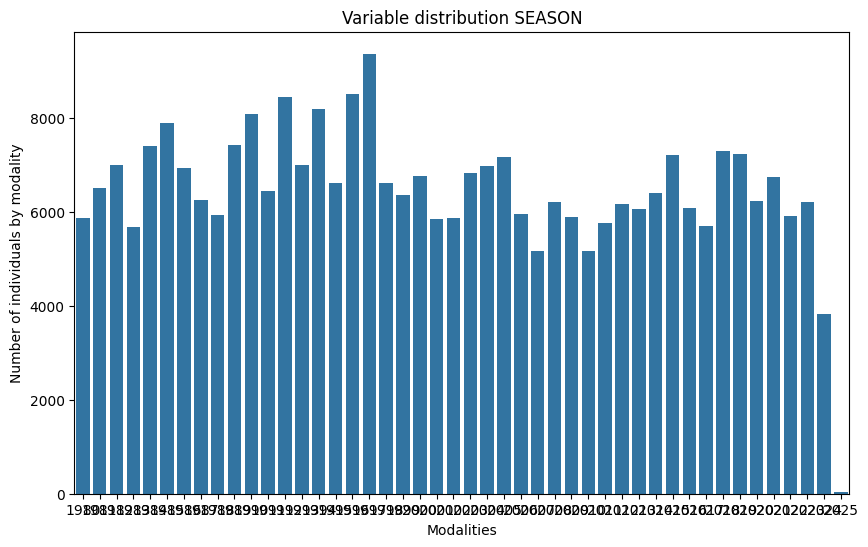

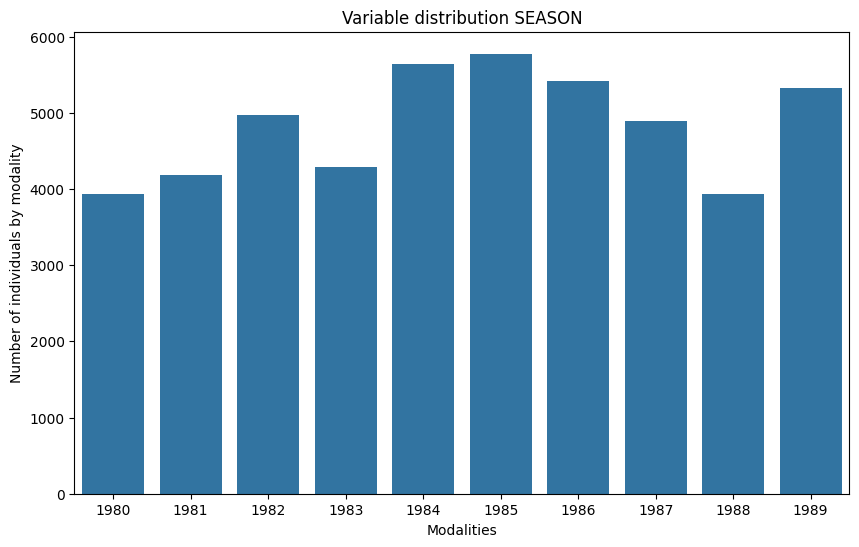

In [22]:
#Using the filtered csv instead of the replaced csv is necessary because of the new values created inside the replaced csv.
distribution("SEASON", df)
distribution("SEASON", filtered_df)

## Variable "WMO_AGENCY" univariate analysis
This variable refers to the agency in charge of the monitoring of the basins.



The unique values in this variable are [' ' 'wellington' 'reunion' 'bom' 'cphc' 'tokyo' 'hurdat_epa' 'hurdat_atl'
 'newdelhi' 'nadi' 'atcf']


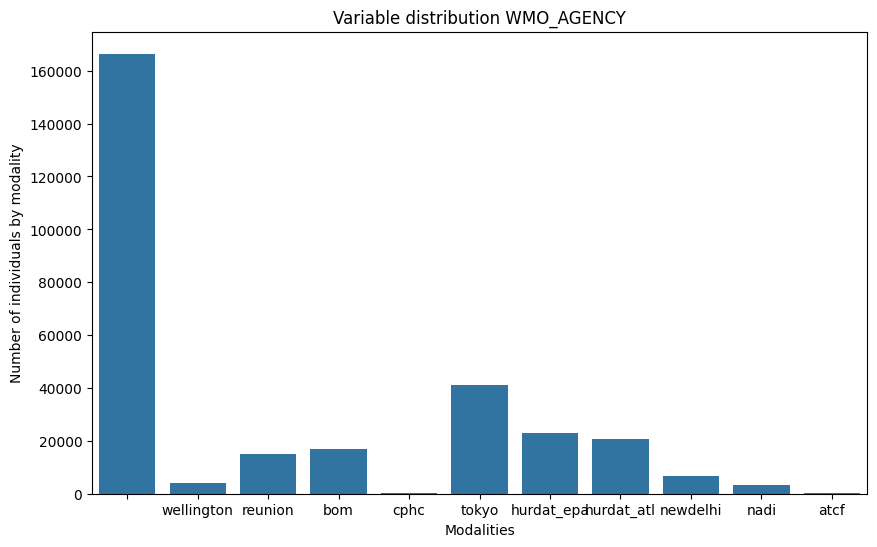

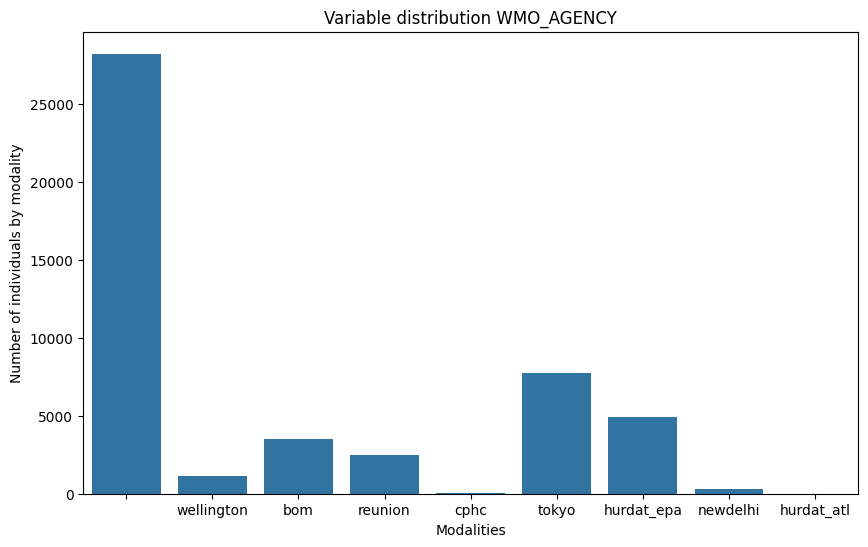

In [23]:
print(f"The unique values in this variable are {df['WMO_AGENCY'].unique()}")
distribution("WMO_AGENCY",df)
distribution("WMO_AGENCY",filtered_df)

We see here that we are losing one agency when using the filtered dataset, but the distrubution looks indetical. We just have less missing values due to the filtering.

In [24]:
df['SEASON'] = pd.to_numeric(df['SEASON'], errors='coerce')
df_reunion = df[df['WMO_AGENCY'] == 'reunion']
df_reunion_filtered = df_reunion[df_reunion['SEASON'] < 1993]

print("Number of rows with WMO_AGENCY='reunion' before 1993 :", len(df_reunion_filtered))
print(df_reunion_filtered['SEASON'].value_counts().sort_index())

df_imd = df[df['WMO_AGENCY'] == 'newdelhi']
df_imd_filtered = df_imd[df_imd['SEASON'] < 1990]

print("\nNumber of rows with WMO_AGENCY='newdelhi' before 1990 :", len(df_imd_filtered))
print(df_imd_filtered['SEASON'].value_counts().sort_index())

Number of rows with WMO_AGENCY='reunion' before 1993 : 3803
SEASON
1980    274
1981    314
1982    289
1983    126
1984    429
1985    293
1986    297
1987    233
1988    322
1989    357
1990    319
1991    181
1992    369
Name: count, dtype: int64

Number of rows with WMO_AGENCY='newdelhi' before 1990 : 578
SEASON
1982    139
1983     61
1984     70
1985     95
1986     24
1987    107
1988     40
1989     42
Name: count, dtype: int64


Indeed, the documentation of the dataset is correct. We have in fact the newly created agency which will be retroactively in charge of certain records, but which are in fact created after them.

## Missing values analysis
Here, we will try to identify any missing values, so that we can start thinking how to handle them.

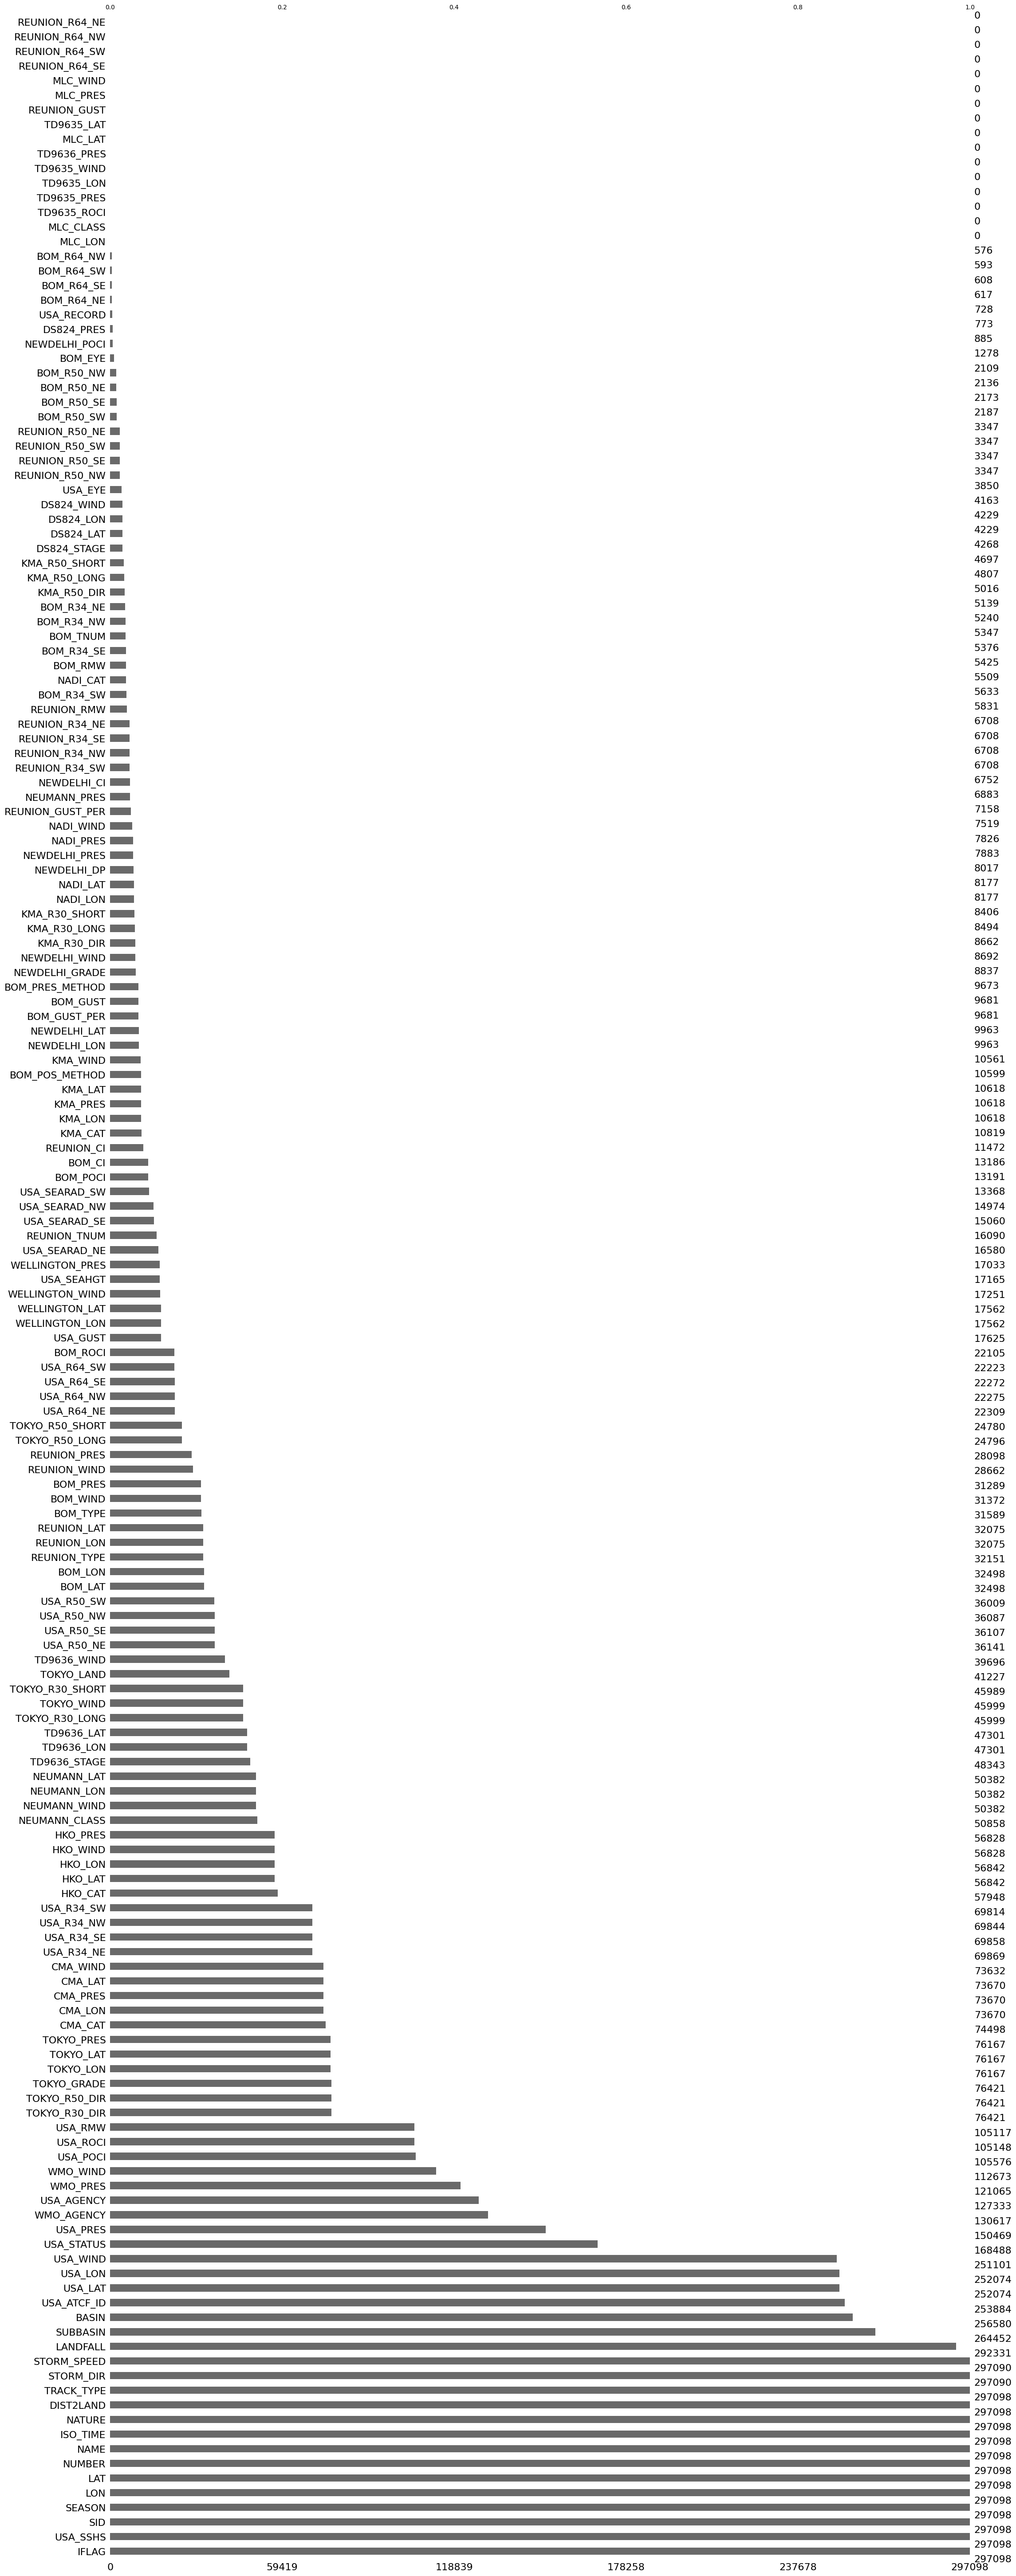

In [25]:
#A new copy of the dataset is here created because we still don't know how to handle the final clean dataset
#We will get reid of all of them soon
miss_values_df = df.copy()
miss_values_df.replace(to_replace=" ", value=pd.NA, inplace=True)

plt.figure(figsize=(10,6))
msno.bar(miss_values_df, sort="descending")
plt.show()

Indeed a lot of missing values are in fact " ", which gives an illusion of missing values.

Now that we have a clear representation of the missing values, we can notice that even for other variable than our target, we have a lot of "blanks". This can be explained by the fact that this dataset is an union of records that have different observation agency source, the latter of which may be equipped differently, or take other criterias in consideration.


# In depth univariate analysis
We will take more time here to study all the different features that seems pertinent on our analysis and see how pertinent they are in our model. Some treatment in the data will need to be done in this step to ensure consistency in the analysis and in the plotting.

As in the previous steps we used different dataframes, where missing values are handled differently, we will need to have more consitency in the treatment of the data.

## Variable "TD9636_STAGE" univariate analysis, and understanding of our target
We later on will need to use this variable in a heatmap and a geographic representation so we will convert it into float.

Let's plot it and try to see if we can notice something from the analysis of this column.

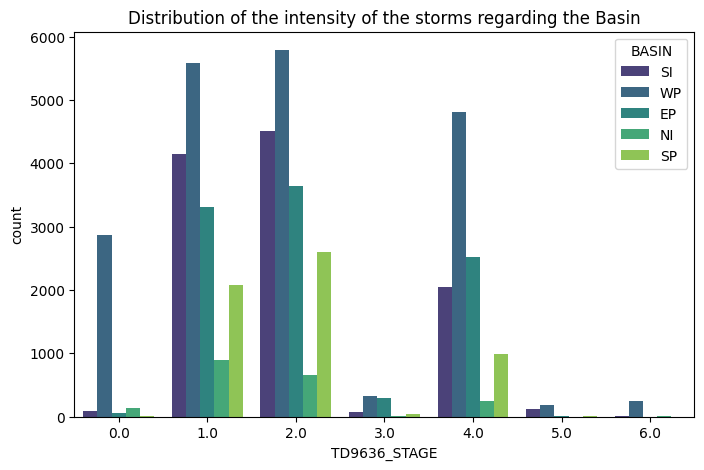

On the Data we have 48343 values that has a point to analyse. Among them, the repartition is at is follow 
TD9636_STAGE
2.0    17204
1.0    16028
4.0    10623
0.0     3156
3.0      742
5.0      331
6.0      259
Name: count, dtype: int64 
Wich gives in percentage TD9636_STAGE
2.0    35.587365
1.0    33.154748
4.0    21.974226
0.0     6.528350
3.0     1.534865
5.0     0.684691
6.0     0.535755
Name: count, dtype: float64


In [26]:
#convert the target into float type for a future use because now it is an object
filtered_df["TD9636_STAGE"] = filtered_df["TD9636_STAGE"].astype(float)

#Class distribution of the intensity of the storms regardin the basin
plt.figure(figsize=(8,5))
sns.countplot(x="TD9636_STAGE", data=filtered_df, hue="BASIN", palette="viridis")
plt.title("Distribution of the intensity of the storms regarding the Basin")
plt.show()

#count of the distribution of the intensity of the storms and the relative information in percentage
total_intensité = len(filtered_df[filtered_df["TD9636_STAGE"] !=7]) #The value 7 will be excluded in the counts as we don't need to care of the corrupted records, they aren't relevant
nombre_intensités = filtered_df["TD9636_STAGE"][filtered_df["TD9636_STAGE"] !=7].value_counts()
print(f"On the Data we have {total_intensité} values that has a point to analyse. Among them, the repartition is at is follow \n{nombre_intensités} \nWich gives in percentage {(nombre_intensités / total_intensité) * 100}")

As we can see in the histogram, the repartition of the target shows quite a bit more of the storm intensity 1, 2 and 4. More than 90% of the datas are in this range. The nature of the dataset itself push us to link more feature together when the storm is active. The variables for the time as well as the location must be taken into account.

In order to see if the location, the basin had, had an impact on the number of storms and their intensity, we created a histogram showcasing the different basins. As we can see, that variable has a huge impact on the analysis. The WP (Western North Pacific) has more storms than the others. The regions in that area of the globe are then more likely to have a storm.

### Spatial representation of the distribution of the intensity of the storms
Here is another way to represent the distribution of the intensity of the storms on a map to see where it occur on the globe.

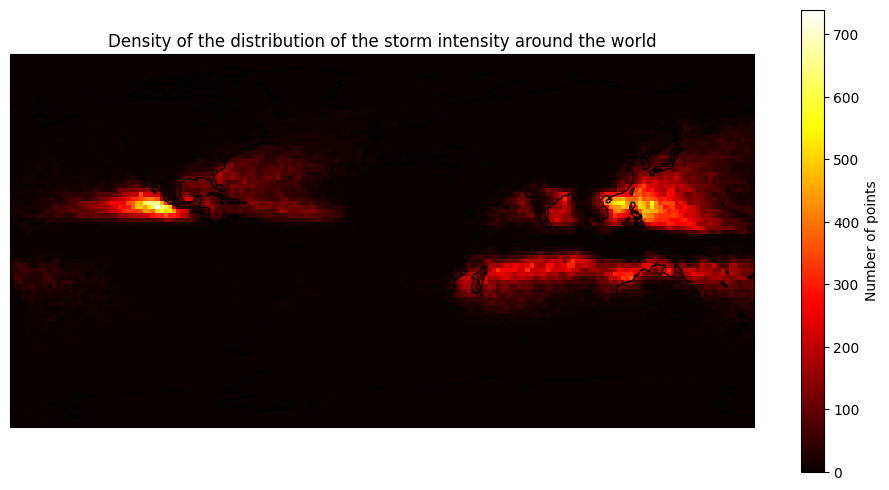

In [27]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.set_global()

lon_bins = np.linspace(-180, 180, 180)
lat_bins = np.linspace(-90, 90, 90)

plt.hist2d(df['LON'], df['LAT'], bins=[lon_bins, lat_bins], transform=ccrs.PlateCarree(), cmap='hot')
plt.colorbar(label="Number of points")

plt.title("Density of the distribution of the storm intensity around the world")
plt.show()

As we can see on this world heat map there are two main point of high density for the storms. One point being in the South of North America  so the Eastern North Pacific Basin (EP) and one in South-East Asia so the Western North Pacific Basin (WP). Which reflect the histogram we created before.

## Temporal variables analysis
The dataset is constructed as a timeline, we all know a storm evolve over time. To ensure consistency in our analysis, we will take some time to identify and understand how the different temporal variable are created. We will then choose one format over the others so that we can easily compare them.

In [28]:
#convert the column ISO_TIME into .datetime() format
filtered_df["ISO_TIME"] = pd.to_datetime(filtered_df["ISO_TIME"], errors="coerce")
filtered_df['YEAR'] = filtered_df['ISO_TIME'].dt.year
filtered_df['MONTH'] = filtered_df['ISO_TIME'].dt.month
print(filtered_df["ISO_TIME"].dtype)

datetime64[ns]


### Analysis of the feature "ISO_TIME" regarding our model
As mentioned before, we only need to focus our analysis and our Machine Learning solution on the target TD9636_STAGE. This beacon has made records for a certain period of time, let's see it more in depth.

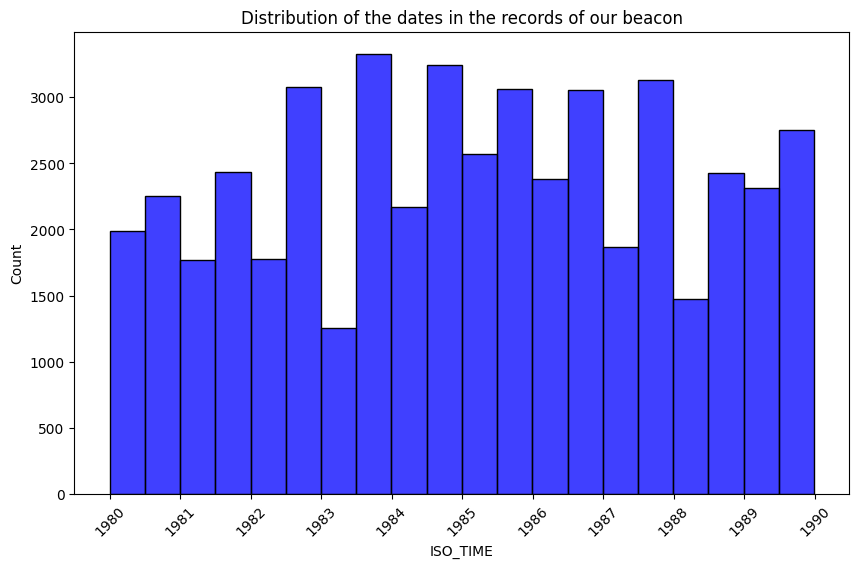

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df["ISO_TIME"], kde=False, color="blue", bins=20)
plt.title("Distribution of the dates in the records of our beacon")
plt.xticks(rotation=45)
plt.show()

Here we can see that our beacon TD9636 has made records from 1980 to 1989. We therefore do not need the previous or following dates.

### Analysis of the lifespan of a storm
As we all know and mentioned before, a storm has a lifespan. It starts somewhere with a given intensity and move along a path, with variations in some parameters. This can be interesting to indentify those parameters and how they behave.

Some stats about the storms
Number of storms : 793
Average lifetime (days) : 7.443673812526272
Median lifetime (days) : 6.875
Max lifetime (days) : 21.625


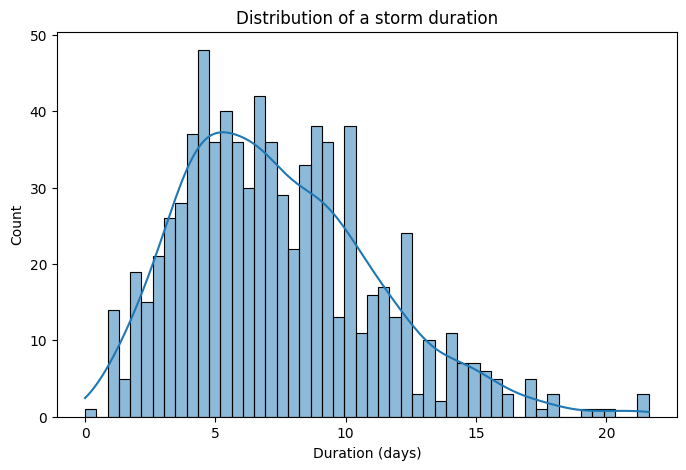

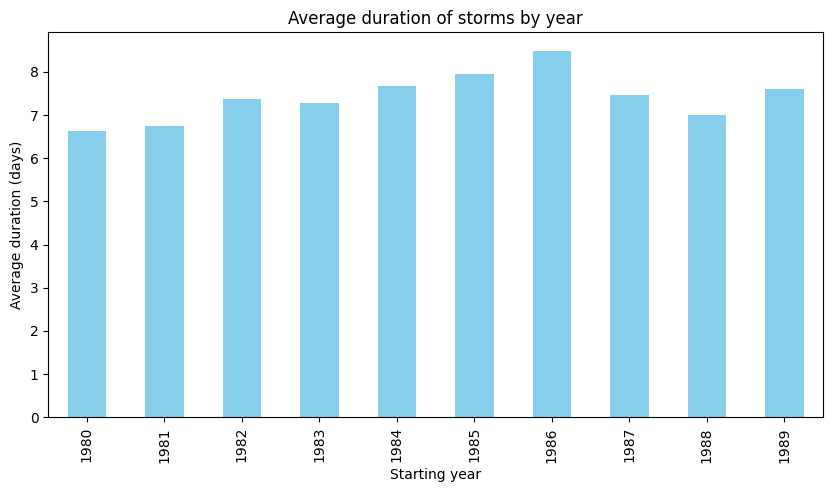

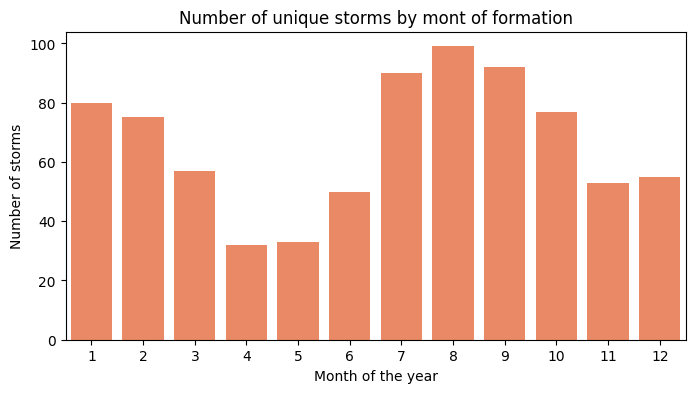

In [30]:
#Average lifetime of a storm
filtered_df = filtered_df.dropna(subset=['ISO_TIME'])

storm_times = filtered_df.groupby('SID')['ISO_TIME'].agg(['min', 'max'])

storm_times['duration_days'] = (storm_times['max'] - storm_times['min']).dt.total_seconds() / (3600 * 24)

print("Some stats about the storms")
print("Number of storms :", len(storm_times))
print("Average lifetime (days) :", storm_times['duration_days'].mean())
print("Median lifetime (days) :", storm_times['duration_days'].median())
print("Max lifetime (days) :", storm_times['duration_days'].max())

plt.figure(figsize=(8,5))
sns.histplot(data=storm_times, x='duration_days', bins=50, kde=True)
plt.xlabel("Duration (days)")
plt.title("Distribution of a storm duration")
plt.show()

storm_times['start_year'] = storm_times['min'].dt.year
storm_times['end_year'] = storm_times['max'].dt.year

annual_stats = storm_times.groupby('start_year')['duration_days'].mean()

plt.figure(figsize=(10,5))
annual_stats.plot(kind='bar', color='skyblue')
plt.title("Average duration of storms by year")
plt.xlabel("Starting year")
plt.ylabel("Average duration (days)")
plt.show()

# Saisonnalité: mois de début
filtered_df['start_month'] = filtered_df.groupby('SID')['ISO_TIME'].transform('min').dt.month
monthly_counts = filtered_df.groupby('start_month')['SID'].nunique().sort_index()

plt.figure(figsize=(8,4))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, color='coral')
plt.title("Number of unique storms by mont of formation")
plt.xlabel("Month of the year")
plt.ylabel("Number of storms")
plt.show()

# Supplément d'idées:
#  - Durée vs intensité max (s'il existe une colonne WMO_WIND, par ex.)
#  - Durée par bassin (BASIN) ou par région
#  - Distribution des durées avant 1980 vs après 2000, etc.

Here we can notice that we have a seasonality for the storms, with more perturbations from July to October.

### Bivariate analysis of the variation of the storm instensity over the time
Lets go a bit further into the analysis of the intensity of the storms over the time.

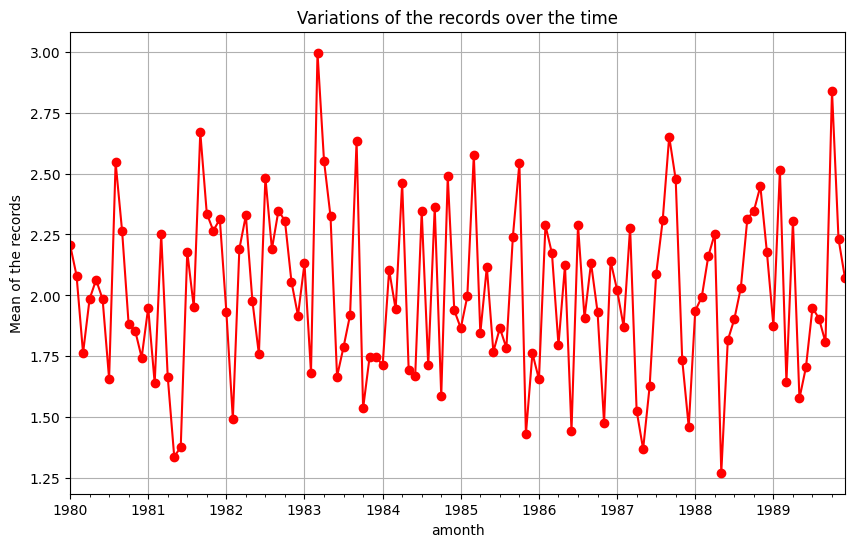

In [31]:
#Average of our target to avoid too much information
filtered_df["amonth"] = filtered_df["ISO_TIME"].dt.to_period("M")

temporal_mean = filtered_df.groupby('amonth')["TD9636_STAGE"].mean()

plt.figure(figsize=(10, 6))
temporal_mean.plot(kind="line", marker="o", color="red")
plt.title("Variations of the records over the time")
plt.ylabel("Mean of the records")
plt.grid(True)
plt.show()

Here we observe a certain redundancy in the recordings, in fact a pattern emerges. The average of these recordings is higher at certain times of the year and redundantly over time. This confirms the seasonality we observed in the previous step.

## Geographic variables analysis
As we did before, we will here take a look at the geographic parameters inside the dataset. First, we already identified LON and LAT regarding TD9636 and we will need to handle them as coordinates, so as float type.

In [32]:
#need to identify how the LON and LAT are handled
print(filtered_df["TD9636_LON"].dtype)
print(filtered_df["TD9636_LAT"].dtype)
#convert object to float(coordinates)
filtered_df["TD9636_LAT"] = pd.to_numeric(filtered_df["TD9636_LAT"], errors="coerce")
filtered_df["TD9636_LON"] = pd.to_numeric(filtered_df["TD9636_LON"], errors="coerce")
#handling Nan in coordinates
print(filtered_df[["TD9636_LON", "TD9636_LAT"]].isna().sum())

#We also have a general LON and LAT, lets see if we have less missing values here
#need to identify how the LON and LAT are handled
print(filtered_df["LON"].dtype)
print(filtered_df["LAT"].dtype)
#convert object to float(coordinates)
filtered_df["LAT"] = pd.to_numeric(filtered_df["LAT"], errors="coerce")
filtered_df["LON"] = pd.to_numeric(filtered_df["LON"], errors="coerce")
#handling Nan in coordinates
print(filtered_df[["LON", "LAT"]].isna().sum())

object
object
TD9636_LON    1042
TD9636_LAT    1042
dtype: int64
float64
float64
LON    0
LAT    0
dtype: int64


### Univariate analysis of the features LON and LAT
Now that the format of the coordinates are handled, let's take a look at this parameter

         TD9636_LAT    TD9636_LON
count  47301.000000  47301.000000
mean       4.860206     61.557183
std       17.438667    109.460767
min      -50.000000   -180.000000
25%      -13.600000     43.000000
50%       12.000000    114.000000
75%       17.800000    140.400000
max       49.000000    180.000000


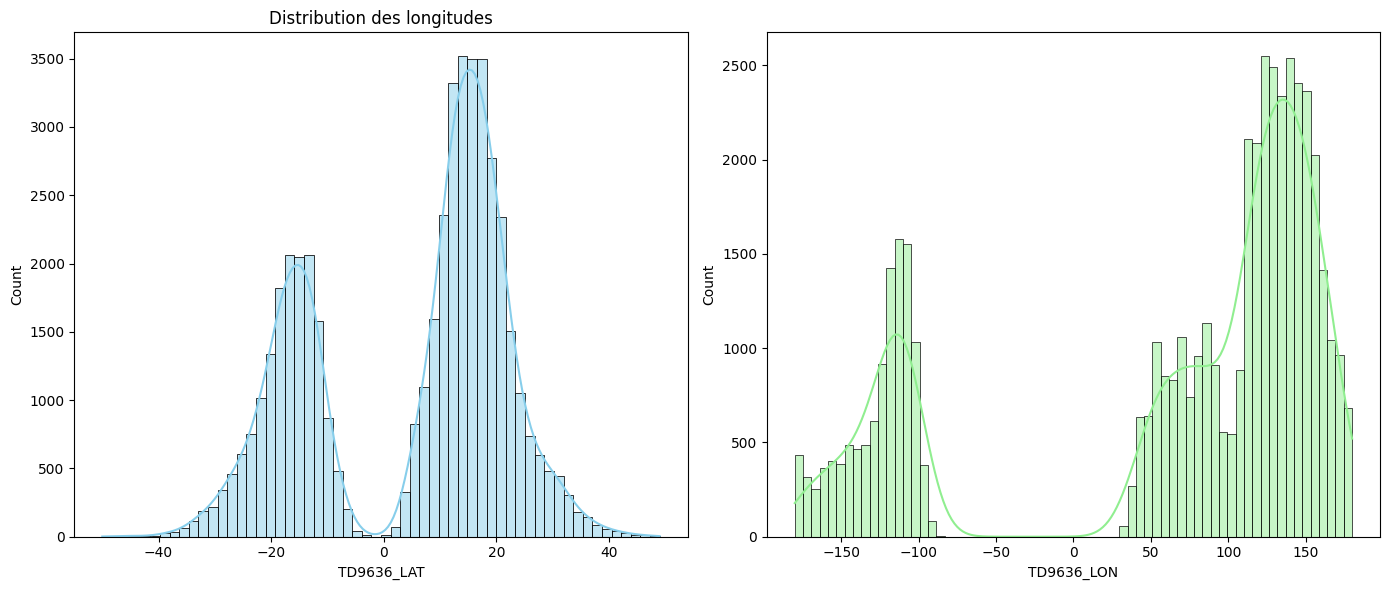

In [33]:
#boxplot of the distribution of LON and LAT
print(filtered_df[["TD9636_LAT", "TD9636_LON"]].describe())

fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.histplot(filtered_df["TD9636_LAT"], kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Distribution des latitudes")

sns.histplot(filtered_df["TD9636_LON"], kde=True, ax=axes[1], color="lightgreen")
axes[0].set_title("Distribution des longitudes")

plt.tight_layout()
plt.show()


This histogram shows us that the records are similarly distributed for LON and LAT, which means that a pattern can be drawn regarding the probability of a storm at a given point in the world.

### Bivariate analysis of the geographic coordinates, regarding our target
We will try to identify the different relationships that may exist between the coordinates and the intensity of the storm.

Let's first look together the relationships betwenn LON and LAT regarding our target.

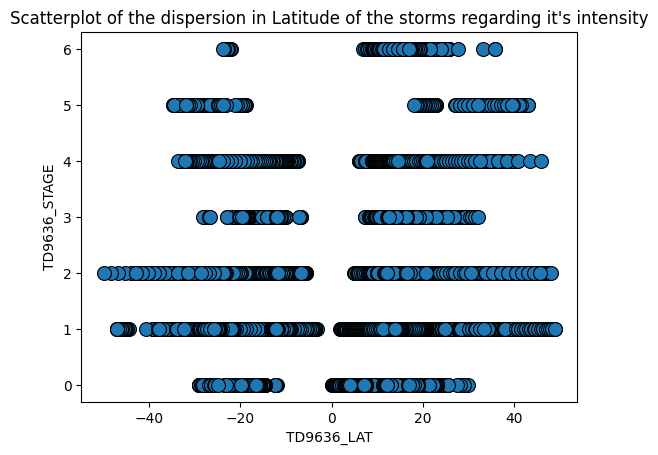

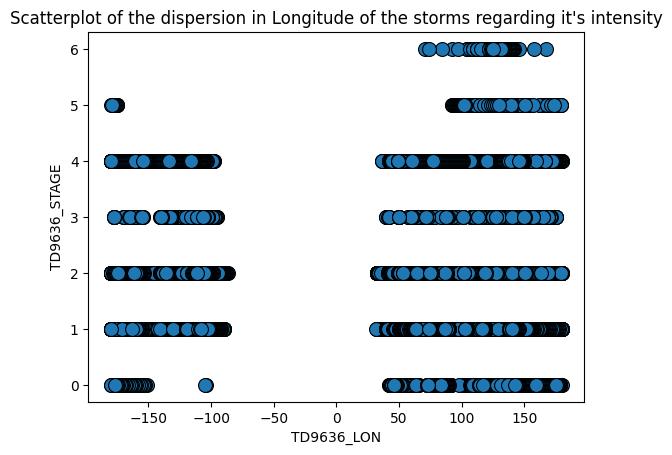

In [34]:
#Bivariate analysis
#scatterplot of the dispersion in Latitude of the storms regarding it's intensity
sns.scatterplot(x="TD9636_LAT", y="TD9636_STAGE", data=filtered_df, s=100, edgecolor="black")
plt.title("Scatterplot of the dispersion in Latitude of the storms regarding it's intensity")
plt.show()

#scatterplot of the dispersion in Longitude of the storms regarding it's intensity
sns.scatterplot(x="TD9636_LON", y="TD9636_STAGE", data=filtered_df, s=100, edgecolor="black")
plt.title("Scatterplot of the dispersion in Longitude of the storms regarding it's intensity")
plt.show()

These two plots confirm our previous observation concerning the geographical distribution of storms. It remains fairly similar, no matter the intensity.

### Spatial representation of the distribution of the records
Here is an interractive map to represent the storms. The slider on the top help us to manage the period of time we want to appear on the map (the two boxes are for the same purpose but with a manual input)

The map has as feature :
- Automatic update of the points when changing the dates into the period slider (or boxes). (Note that in some case this may take time).
- There is an automatic link made between records to track the path of the storm. It can be filtered inside the code (to change the max distance between two points and max time between two records. Here is 300km and 48hours).
- The dots are the records and are colored regarding their intensity.
- A mouseover on a point gives us more information about this record.

In [81]:
#creation of a slider and its limits for ISO TIME
min_date, max_date = filtered_df['ISO_TIME'].min(), filtered_df['ISO_TIME'].max()

interractive_slider = widgets.SelectionRangeSlider(
    options=[date.strftime("%Y-%m-%d") for date in pd.date_range(min_date, max_date)],
    index=(0,len(pd.date_range(min_date, max_date)) - 1),
    description="Date Range",
    orientation="horizontal",
    layout={"width": "80%"}
)

#ability to update the map according to the selected date range
def update_map(date_range):
    """
    Argument: slider date range
    retrun: the map
    """
    start_date, end_date = pd.to_datetime(date_range)
    filtered_map = filtered_df[(filtered_df['ISO_TIME'] >= start_date) & (filtered_df['ISO_TIME'] <= end_date)]

    #map creation
    carte = folium.Map(location=[filtered_df['LAT'].mean(), filtered_df['LON'].mean()], zoom_start=5)

    #create cluster and add points from target
    map_cluster = MarkerCluster().add_to(carte)
    for _, row in filtered_map.iterrows():
        folium.CircleMarker(
            location=[row['LAT'], row['LON']],
            radius=5,
            fill=True,
            fill_opacity=0.8,
            popup=f"Date: {row['ISO_TIME'].date()}<br>Target: {row['TD9636_STAGE']}", #info au clic de la souris
            tooltip=f"Date: {row['ISO_TIME'].date()}<br>Target: {row['TD9636_STAGE']}<br>Location: {row['BASIN']}<br>Nature: {row}" #info au mouseover
        ).add_to(map_cluster)

    #relink added points for better readability, and in time order
    filtered_map = filtered_map.sort_values("ISO_TIME")

    #coordinates = filtered_map[["TD9636_LAT", "TD9636_LON"]].values.tolist()
    #filter lines to connect only nearby points (for v1 with only 1 filter, replace function name and 1st parameter with var coordinates)
    filtered_lines = filter_close_points_with_time(filtered_df, max_distance_km=300)

    #add filtered segments
    for segment in filtered_lines:
        folium.PolyLine(segment, color="blue", weight=2.5, opacity=0.7).add_to(carte)
    return carte

#interactive display function
def interractive_map(date_range):
    display(update_map(date_range))

#Because of the huge size of the data set, and to avoid having too many points connected for nothing, we're going to add a function to create a threshold that will only connect nearby points.

#To prevent segmentation from connecting two points that are close in distance but not in ISO_TIME, we've added a new filter.
def filter_close_points_with_time(filtered_csv, max_distance_km=1000, max_time_diff_hours=12):

    lines = []

    #Sort ISO_TIME to iterate in a chronological order, and create a new index from this sorting to avoid any index conflict
    filtered_csv = filtered_csv.sort_values("ISO_TIME").reset_index(drop=True)

    #goal is to go in the points of the DF to see 1. if they are close by Geographically 2. if they are close by in the Timeline
    for i in range(len(filtered_csv) - 1): #iterate until the penultiem element to compare each element with the previous one
        point1 = (filtered_csv.loc[i, "LAT"], filtered_csv.loc[i, "LON"]) #access the LAT and LON at i point
        point2 = (filtered_csv.loc[i + 1, "LAT"], filtered_csv.loc[i + 1, "LON"]) #access the LAT and LON at i+1 point, gives two successive points
    #After several tests we are using LON and LAT instead of TD9636_... because of the NaN in the second one.

        time_diff = (filtered_csv.loc[i + 1, "ISO_TIME"] - filtered_csv.loc[i, "ISO_TIME"]).total_seconds() / 3600 #the operation return a timedelta, .total_second convert into seconds, and /3600 for hours
        distance = geodesic(point1, point2).km #function to mesure a distance between 2 points, in km

        if distance < max_distance_km and time_diff < max_time_diff_hours: #check if max_distance and max_time are respected
            lines.append([point1, point2]) #if yes, then the coordinates the point is added to the line

    return lines

widgets.interactive(interractive_map, date_range=interractive_slider)

interactive(children=(SelectionRangeSlider(description='Date Range', index=(0, 3650), layout=Layout(width='80%…

### Spatial reprensentation of the trajectories of the storms
Here, from a global point of view, we'll look at storm tracks over the period TD636 has been recording data, to see if they have a preferred path.

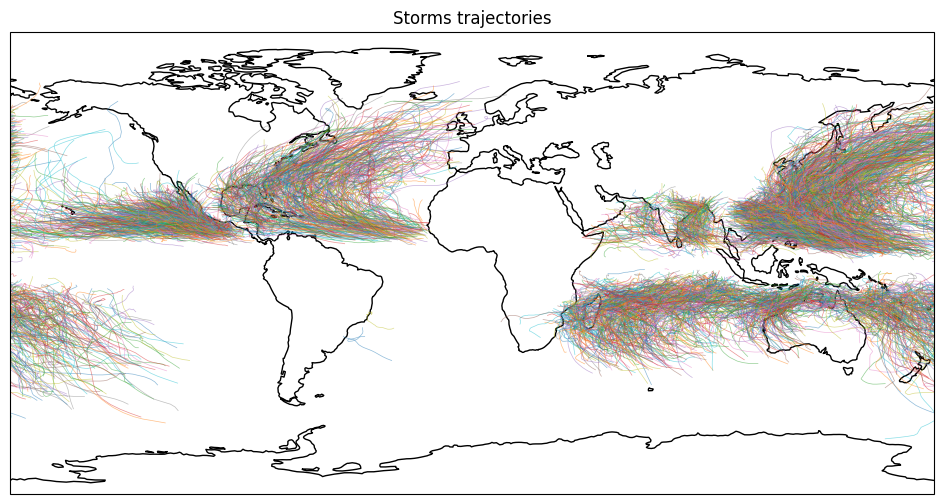

In [36]:
grouped = df.groupby('SID')

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.set_global()

for sid, group in grouped:
    group = group.sort_values('ISO_TIME')
    plt.plot(group['LON'], group['LAT'], transform=ccrs.PlateCarree(), linewidth=0.5, alpha=0.5)

plt.title("Storms trajectories")
plt.show()

# Multivariate analysis and other interesting features
We already identified some mandatory features in our model. We now need to study more features to see if they are relevant for the base or for the others features we may add to the model.

## Representation of the wind speed in the storms
The wind speed is a factor that can impact a lot for a storm. Indeed, it can raise its movement speed and maybe some other parameters that we will try to identify.

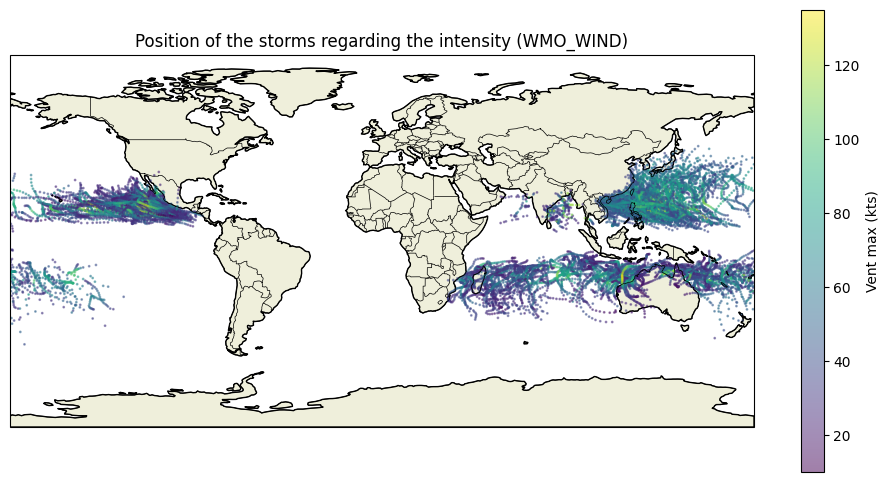

In [37]:
#To avoid errors we need to handle the wind speed into numbers instead of objects
filtered_df['WMO_WIND'] = pd.to_numeric(filtered_df['WMO_WIND'], errors='coerce')


norm = mcolors.Normalize(vmin=filtered_df['WMO_WIND'].min(), vmax=filtered_df['WMO_WIND'].max(), clip=True)
cmap = plt.cm.viridis

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.set_global()

scatter = plt.scatter(
    filtered_df['LON'], filtered_df['LAT'],
    c=filtered_df['WMO_WIND'], cmap=cmap, norm=norm,
    s=1, transform=ccrs.PlateCarree(), alpha=0.5
)
plt.colorbar(scatter, label="Vent max (kts)")
plt.title("Position of the storms regarding the intensity (WMO_WIND)")
plt.show()

## Distribution of the storms regarding their coastal distance
We will try to see if we are more likely to have a storm in the middle of the ocean compared to the land.

In [38]:
filtered_df['DIST2LAND'] = pd.to_numeric(filtered_df['DIST2LAND'], errors='coerce')
df_dist = filtered_df.dropna(subset=['DIST2LAND'])

count_under_100 = (df_dist['DIST2LAND'] < 100).sum()
print(f"Number of observations at < 100 km of the sea coast : {count_under_100}")


bins = [0, 100, 200, 500, np.inf]
labels = ["<100km", "100-200km", "200-500km", "500km+"]
df_dist['DIST_CAT'] = pd.cut(df_dist['DIST2LAND'], bins=bins, labels=labels)

print("\nDistribution of the observations by distance class :")
print(df_dist['DIST_CAT'].value_counts())

df_min_dist = df_dist.groupby('SID')['DIST2LAND'].min().reset_index(name='MIN_DIST2LAND')
tempetes_under_100 = (df_min_dist['MIN_DIST2LAND'] < 100).sum()
print(f"\nNumber of storms that have been at <100 km of the sea coast : {tempetes_under_100}")

Number of observations at < 100 km of the sea coast : 5318

Distribution of the observations by distance class :
DIST_CAT
500km+       29024
200-500km    10528
100-200km     3413
<100km        3029
Name: count, dtype: int64

Number of storms that have been at <100 km of the sea coast : 391


## Multivariate analysis
The nature itself of the dataset push us to try to correlate all the parameters we have seen above to try to establish the schema.

First we will try a correlation matrix to see the linearity of the relation between LON, LAT and STAGE

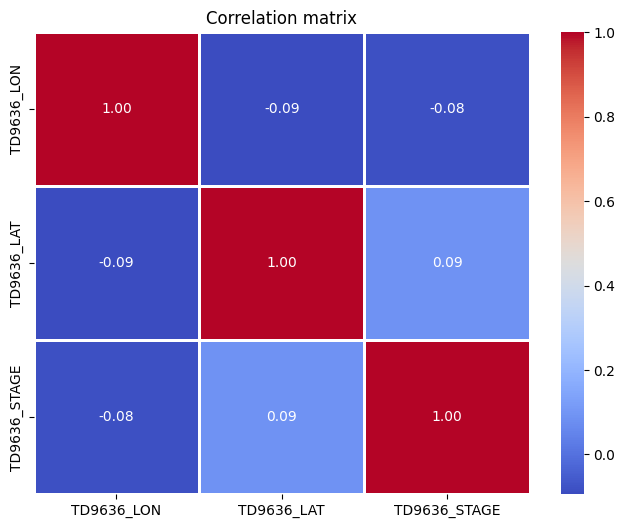

In [39]:
#Correlation matrix heatmap
corr = filtered_df[["TD9636_LON", "TD9636_LAT", "TD9636_STAGE"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=1)
plt.title("Correlation matrix")
plt.show()

We see that the matrix is arranged in a symetric way, that means that we have a link between these three parameters.

# Preparing the dataset

## Cleaning the dataset

In [40]:
df_prod['SEASON'] = pd.to_numeric(df_prod['SEASON'], errors='coerce')
df_prod['ISO_TIME'] = pd.to_datetime(df_prod['ISO_TIME'], errors='coerce')
df_prod['YEAR'] = df_prod['ISO_TIME'].dt.year
df_prod['MONTH'] = df_prod['ISO_TIME'].dt.month
df_prod['start_month'] = df_prod.groupby('SID')['ISO_TIME'].transform('min').dt.month
df_prod['WMO_WIND'] = pd.to_numeric(df_prod['WMO_WIND'], errors='coerce')
df_prod['LAT'] = pd.to_numeric(df_prod['LAT'], errors='coerce')
df_prod['LON'] = pd.to_numeric(df_prod['LON'], errors='coerce')
df_prod['DIST2LAND'] = pd.to_numeric(df_prod['DIST2LAND'], errors='coerce')
df_prod.replace(to_replace=" ", value=pd.NA, inplace=True)

## Feature engineering

### Temporal variables

Creation of a storm start variable and the age of the current storm

In [41]:
df_prod['start_date'] = df_prod.groupby('SID')['ISO_TIME'].transform('min')
df_prod['age_hours'] = (df_prod['ISO_TIME'] - df_prod['start_date']).dt.total_seconds() / 3600

In [42]:
variables_temporelles = ["start_date","age_hours","SEASON","ISO_TIME","YEAR","MONTH","start_month"]

In [43]:
variable_cible = 'TD9636_STAGE'


In [44]:
df_prod = df_prod.dropna(subset=[variable_cible])

In [45]:
df_prod["age_hours"]

0          0.0
1          3.0
2          6.0
3          9.0
4         12.0
         ...  
67405    216.0
67406    219.0
67407    222.0
67408    225.0
67409    228.0
Name: age_hours, Length: 48343, dtype: float64

In [46]:
df_temporel = df_prod[variables_temporelles + [variable_cible]].copy()


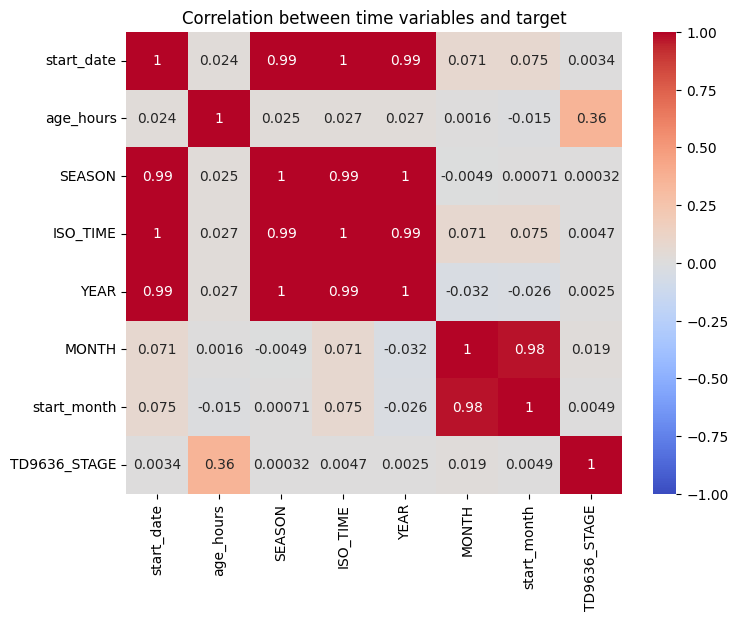

In [47]:
df_temporel[variable_cible] = pd.to_numeric(df_temporel[variable_cible], errors='coerce')
corr_mat = df_temporel.corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation between time variables and target")
plt.show()

We notice that the only temporal variable that seems to be correlated with the target variable is the age_hours variable we've created.
We'll try to confirm this with a random forest.

In [48]:
df_temporel = df_temporel.drop(columns=['start_date', 'ISO_TIME'])
variables_temporelles = ["age_hours","SEASON","YEAR","MONTH","start_month"]

       feature  importance
0    age_hours    0.637232
4  start_month    0.094307
3        MONTH    0.091408
1       SEASON    0.088918
2         YEAR    0.088135


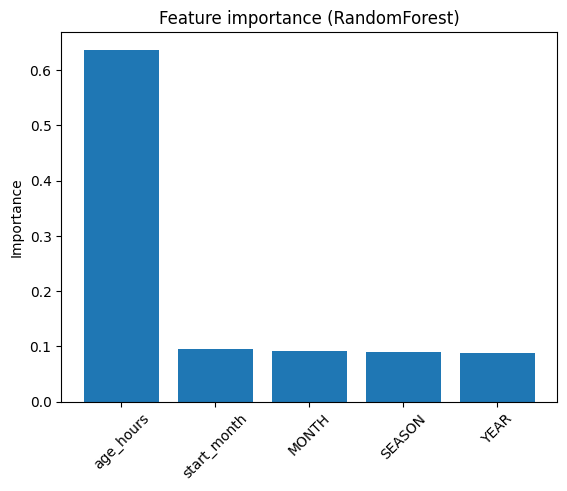

In [49]:
le = LabelEncoder()
df_temporel[variable_cible] = le.fit_transform(df_temporel[variable_cible])


X = df_temporel[variables_temporelles]
y = df_temporel[variable_cible]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importance_variables_temporelles = rf.feature_importances_
df_importance_variables_temporelles = pd.DataFrame({
    'feature': variables_temporelles,
    'importance': importance_variables_temporelles
}).sort_values('importance', ascending=False)

print(df_importance_variables_temporelles)

plt.bar(df_importance_variables_temporelles['feature'], df_importance_variables_temporelles['importance'])
plt.title("Feature importance (RandomForest)")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()

Random forest confirms the importance of a single variable: the age of the storm in hours. So we're going to delete the others.

In [50]:
variables_to_drop = ["ISO_TIME","start_date","SEASON","YEAR","MONTH","start_month"]
df_prod = df_prod.drop(columns = variables_to_drop)

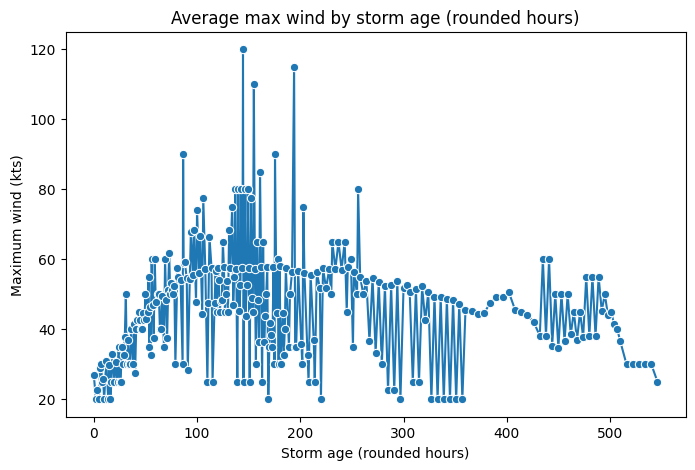

In [51]:
df_plot = df_prod.groupby('age_hours')['WMO_WIND'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.lineplot(data=df_plot, x='age_hours', y='WMO_WIND', marker='o')
plt.title("Average max wind by storm age (rounded hours)")
plt.xlabel("Storm age (rounded hours)")
plt.ylabel("Maximum wind (kts)")
plt.show()

### Mutualization of location variables into a single variable

We notice that some variables are the same, but named by zone. For example, we can separate all the latitude and longitude variables from the global variables, as they duplicate each other.

In [52]:
df_prod[["TD9636_LAT","TD9636_LON","LAT","LON"]].sample(20)

,TD9636_LAT,TD9636_LON,LAT,LON
25226,-10.8,55.6,-10.5,55.7
23548,16.9,-136.0,16.9,-136.0
52935,<NA>,<NA>,15.3,78.2
6674,-18.2,115.6,-18.2,115.7
26071,-15.3,81.2,-15.1,81.0
17001,8.3,148.1,8.9,148.2
7411,-16.8,148.2,-16.8,148.4
40553,<NA>,<NA>,-26.1,55.1
37689,13.0,-102.9,13.0,-102.8
45843,16.3,-105.6,16.3,-105.6


TD_9636 LAT and LON will not be kept as they have missing values.

In [53]:
df_prod = df_prod.drop(columns=[col for col in df_prod.columns if col.endswith('_LON') or col.endswith('_LAT')])
print(f"There are {df_prod.shape[1]} remaining variables")

There are 143 remaining variables


### Variable WMO_WIND

This is the maximum sustained wind speed recorded by the official meteorological agency (WMO). The problem is that the sampling periods are different in different zones (1min or 3 min or 10min). So the variable has to be corrected so that the different zones are comparable. To do this, we researched the subject, and came across a scientific article which explains how to correct this problem by applying ratios to the variable as a function of storm location and sampling time. \
Here is the link:  \
https://www.systemsengineeringaustralia.com.au/download/WMO_TC_Wind_Averaging_27_Aug_2010.pdf

This is table 1.1

In [54]:
# Definition of a function to determine the agency sampling period
def determine_averaging_period(agency):
    mapping = {
        'hurdat_atl': '1min',
        'hurdat_epa': '1min',
        'cphc': '1min',
        'tokyo': '10min',
        'newdelhi': '3min',
        'reunion': '10min',
        'bom': '10min',
        'nadi': '10min',
        'wellington': '10min'
    }
    return mapping.get(agency, '10min')  # Defaults to 10 min if not specified

# Function to apply conversion ratios according to location and sampling time
def apply_wind_conversion(row):
    dist = row['DIST2LAND']
    wind_speed = row['WMO_WIND']
    agency = row['WMO_AGENCY']

    # Determine sampling time
    avg_period = determine_averaging_period(agency)

    # Determining the exposure category based on DIST2LAND
    if dist > 20:
        exposure_ratios = {'1min': 1, '3min': 1, '10min': 1.05}
    elif dist <= 1:
        exposure_ratios = {'1min': 1, '3min': 1.10, '10min': 1.16}
    else:
        exposure_ratios = {'1min': 1, '3min': 1.05, '10min': 1.11}

    return wind_speed * exposure_ratios[avg_period]


df_prod['WMO_WIND_ADJUSTED'] = df_prod.apply(apply_wind_conversion, axis=1)

As mentioned above, the ratios are assigned in relation to sample duration and location (i.e. whether the storm is at sea or close to the coast. To know this, we can rely on the variable DIST2LAND).

### Different wind speed measurements

We try to understand the relationship between the different variables, in particular the difference between WMO_WIND and TD9636_WIND.

In [55]:
df_prod[["TOKYO_WIND","USA_WIND","HKO_WIND","CMA_WIND","NEUMANN_WIND","TD9636_WIND","WMO_WIND","SID","NAME","BASIN","SUBBASIN","USA_WIND"]].sample(5)


,TOKYO_WIND,USA_WIND,HKO_WIND,CMA_WIND,NEUMANN_WIND,TD9636_WIND,WMO_WIND,SID,NAME,BASIN,SUBBASIN,USA_WIND
48326,<NA>,<NA>,<NA>,<NA>,25,20,NaN,1987036S15066,BEMAZAVA,SI,MM,<NA>
17711,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,1982248N14133,IRVING,WP,MM,<NA>
31659,40,55,38,48,<NA>,54,NaN,1984302N00149,AGNES,WP,MM,55
25562,<NA>,<NA>,<NA>,<NA>,38,34,NaN,1983359S13083,SHARON,SI,MM,<NA>
6734,<NA>,25,<NA>,<NA>,25,25,NaN,1981015S09078,GAELLE,SI,MM,25


WMO_WIND = official measurement (according to the corresponding WMO agency), but the averaging period varies by region (1, 3 or 10 minutes), which can complicate direct comparison between different zones. \
TD9636_WIND = (subjective) estimate of maximum instantaneous speed, homogenized over a 1-minute period, but with fewer “official” guarantees and more uncertainties (hence the warning on interpretation).

Ideas: WMO_WIND_ADJUSTED can be used first, adjusted with the ratios found, and NaNs can be completed with TD9636_WIND values where available.
The rest of the NaNs can be completed with the values of before and after in the storm chronology.

In [56]:
# Execution
# Replacing the first missing values by the ones from TD936_WIND
df_prod['WMO_WIND_ADJUSTED_COMPLETED'] = df_prod['WMO_WIND_ADJUSTED'].fillna(df_prod['TD9636_WIND'])

In [57]:
#Replacing the last missing values with the averages of the first preceding and following non-zero values.
df_prod['WMO_WIND_ADJUSTED_COMPLETED'] = pd.to_numeric(
    df_prod['WMO_WIND_ADJUSTED_COMPLETED'],
    errors='coerce'
)

# Improvement: when several NaN values in a row, gradually increase or decrease the values.

In [58]:
df_prod = df_prod.sort_values(by=['SID', 'age_hours'])

df_prod['forward'] = df_prod.groupby('SID')['WMO_WIND_ADJUSTED_COMPLETED'].ffill()
df_prod['backward'] = df_prod.groupby('SID')['WMO_WIND_ADJUSTED_COMPLETED'].bfill()

def fill_value(row):
    original = row['WMO_WIND_ADJUSTED_COMPLETED']
    if not pd.isna(original):
        return original

    f = row['forward']
    b = row['backward']

    if pd.isna(f) and pd.isna(b):
        return np.nan
    if pd.isna(b):
        return f
    if pd.isna(f):
        return b
    return (f + b) / 2

df_prod['WMO_WIND_ADJUSTED_COMPLETED'] = df_prod.apply(fill_value, axis=1)
df_prod.drop(columns=['forward', 'backward'], inplace=True)

We've decided to keep only WMO_WIND_ADUJUSTED_COMPLETED among the wind variables. In fact, it's an improvement on WMO_WIND_ADJUSTED, WMO_WIND and TD9636_WIND. In addition, the other wind variables correspond either to a different zone than the storm zone, or to the storm zone, but are duplicates.

In [59]:
df_prod = df_prod.drop(columns=["WMO_WIND_ADJUSTED","WMO_WIND","TD9636_WIND","USA_WIND","TOKYO_WIND","CMA_WIND","HKO_WIND",
                     "NEUMANN_WIND"])

### Removal of variables with too high a proportion of NA

We consider that above a certain threshold, the NAs become complicated to replace and the model will have difficulty using the variables in its predictions.

In [60]:
threshold = 0.5
nan_ratio = df_prod.isna().mean()
df_prod = df_prod.loc[:, nan_ratio < threshold]
print(f"There are {df_prod.shape[1]} variables left")

There are 19 variables left


In [61]:
df_prod = df_prod.drop(columns=["SID","NUMBER","SUBBASIN","NAME","USA_ATCF_ID"])


In [62]:
df_prod['STORM_SPEED'] = pd.to_numeric(df_prod['STORM_SPEED'], errors='coerce').astype('Int64')

for col in ['BASIN', 'NATURE', 'TRACK_TYPE', 'LANDFALL', 'IFLAG', 'STORM_DIR']:
    df_prod[col] = df_prod[col].astype('category')

# Model creation

### First simple model (Linear Regression)

Mean Squared Error: 0.61
R^2 Score: 0.63


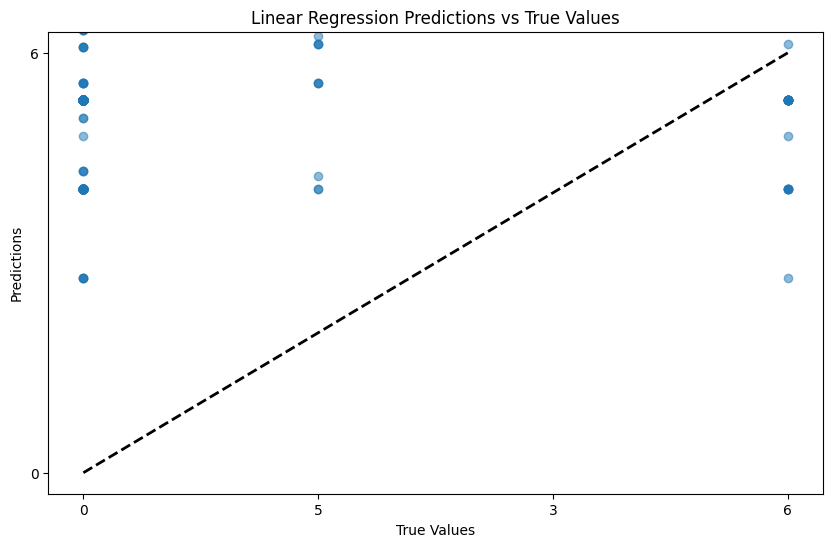

In [63]:
df_clean = df_prod[['TD9636_STAGE', 'WMO_WIND_ADJUSTED_COMPLETED']].dropna()
target = 'TD9636_STAGE'

X = df_clean["WMO_WIND_ADJUSTED_COMPLETED"].values.reshape(-1, 1)

train_test_split_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, df_clean[target], test_size=train_test_split_ratio, random_state=42)
LinearRegression_model = LinearRegression()
LinearRegression_model.fit(X_train, y_train)
y_pred = LinearRegression_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Linear Regression Predictions vs True Values')
plt.show()

### More complex model (XGBoost)

In [64]:
df_prod['TD9636_STAGE'] = df_prod['TD9636_STAGE'].astype('category').cat.codes

### Test with the remaining columns

In [65]:
X = df_prod.drop(columns=['TD9636_STAGE'], errors='ignore').copy()
y = df_prod['TD9636_STAGE'].copy()

In [66]:
def evaluate_model(X_data, y_data):
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
    )
    model = XGBClassifier(
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='mlogloss',
        enable_categorical=True,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    return f1, acc



f1, acc = evaluate_model(X, y)

print("=== Results for the first model ===")
print(f"F1-score (macro) : {f1:.3f}")
print(f"Accuracy        : {acc:.3f}")

c:\Users\CM_LAPTOP\.conda\envs\Tropical_Strengh\Lib\site-packages\xgboost\training.py:183: UserWarning:

[20:26:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




=== Results for the first model ===
F1-score (macro) : 0.819
Accuracy        : 0.908


### Test with a method to find the best feature combination

In [67]:
best_features = []
remaining_features = list(X.columns)
best_score = 0.0

while True:
    improved = False
    best_candidate = None
    
    for candidate in remaining_features:
        
        current_subset = best_features + [candidate]
        f1, acc = evaluate_model(X[current_subset], y)  
        
        if acc > best_score:
            best_score = acc
            best_candidate = candidate
            improved = True
    
    if improved:
        best_features.append(best_candidate)
        remaining_features.remove(best_candidate)
    else:
        break

print("Meilleur sous-ensemble : ", best_features)

c:\Users\CM_LAPTOP\.conda\envs\Tropical_Strengh\Lib\site-packages\xgboost\training.py:183: UserWarning:

[20:26:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\CM_LAPTOP\.conda\envs\Tropical_Strengh\Lib\site-packages\xgboost\training.py:183: UserWarning:

[20:26:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\CM_LAPTOP\.conda\envs\Tropical_Strengh\Lib\site-packages\xgboost\training.py:183: UserWarning:

[20:26:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\CM_LAPTOP\.conda\envs\Tropical_Strengh\Lib\site-packages\xgboost\training.py:183: UserWarning:

[20:26:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\CM_LAPTOP\.conda\envs\Tropical_Strengh\

Meilleur sous-ensemble :  ['USA_SSHS', 'WMO_WIND_ADJUSTED_COMPLETED', 'NATURE', 'LON', 'age_hours', 'LAT', 'DIST2LAND', 'STORM_SPEED', 'BASIN']


In [68]:
X = df_prod[best_features].copy()
y = df_prod['TD9636_STAGE'].copy()

f1, acc = evaluate_model(X, y)

print("=== Résults ===")
print(f"F1-score (macro) : {f1:.3f}")
print(f"Accuracy        : {acc:.3f}")

c:\Users\CM_LAPTOP\.conda\envs\Tropical_Strengh\Lib\site-packages\xgboost\training.py:183: UserWarning:

[20:30:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




=== Résults ===
F1-score (macro) : 0.886
Accuracy        : 0.932


### Hyper parameters optimization with grid search 

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



model = XGBClassifier(
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='mlogloss',
        enable_categorical=True,
        random_state=42
    )


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


acc_scorer = make_scorer(accuracy_score)


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=acc_scorer,  
    cv=5,                
    verbose=1,           
    n_jobs=-1)          

grid_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score (Accuracy CV) :", grid_search.best_score_)
best_model = grid_search.best_estimator_


y_pred_test = best_model.predict(X_test)
print("Accuracy sur le test set :", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\CM_LAPTOP\.conda\envs\Tropical_Strengh\Lib\site-packages\xgboost\training.py:183: UserWarning:

[20:38:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Meilleurs hyperparamètres : {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Meilleur score (Accuracy CV) : 0.9322283575959476
Accuracy sur le test set : 0.9415658289378426
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       631
           1       0.95      0.96      0.95      3206
           2       0.93      0.94      0.93      3441
           3       0.75      0.51      0.61       148
           4       0.94      0.94      0.94      2125
           5       0.94      0.89      0.91        66
           6       1.00      0.85      0.92        52

    accuracy                           0.94      9669
   macro avg       0.93      0.87      0.89      9669
weighted avg       0.94      0.94      0.94      9669



### Final model (with feature selection, and hyper parameters optimization)

In [70]:
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.2,
    'max_depth': 7,
    'n_estimators': 200,
    'subsample': 0.8
}

final_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    enable_categorical=True,  
    **best_params
)


final_model.fit(X_train, y_train)


y_pred = final_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print(classification_report(y_test, y_pred))

c:\Users\CM_LAPTOP\.conda\envs\Tropical_Strengh\Lib\site-packages\xgboost\training.py:183: UserWarning:

[20:38:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Accuracy: 0.9415658289378426
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       631
           1       0.95      0.96      0.95      3206
           2       0.93      0.94      0.93      3441
           3       0.75      0.51      0.61       148
           4       0.94      0.94      0.94      2125
           5       0.94      0.89      0.91        66
           6       1.00      0.85      0.92        52

    accuracy                           0.94      9669
   macro avg       0.93      0.87      0.89      9669
weighted avg       0.94      0.94      0.94      9669



In [71]:
df_comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

In [72]:
df_comparison.sample(20)

,Actual,Predicted
66546,4,4
63287,1,1
31512,2,2
14194,2,2
16079,4,4
9123,0,0
41920,1,1
40381,2,2
64150,3,3
6069,1,1


In [73]:
df_prod['TD9636_STAGE'].value_counts(normalize=True) * 100

TD9636_STAGE
2    35.587365
1    33.154748
4    21.974226
0     6.528350
3     1.534865
5     0.684691
6     0.535755
Name: proportion, dtype: float64

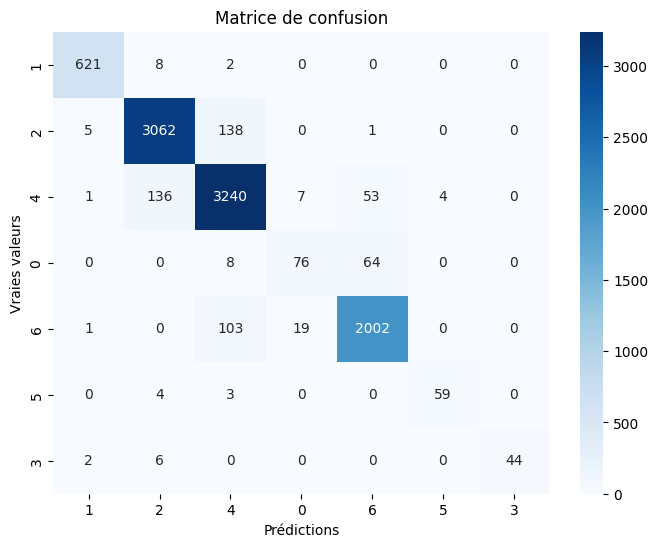

In [74]:
y_pred = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=df_prod['TD9636_STAGE'].unique(), yticklabels=df_prod['TD9636_STAGE'].unique())
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

Performances analysis of the model : 
- Good F1 score
However : 
- The class 3 isn't well predicted, and the minoritary classes in general. 
Potential way of solving that problem : trying to do some oversampling to increase the number of observations in the minoritary classes.